In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("retentiondata_case.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (5636, 36)
Columns: ['acct_ref', 'cust_ref', 'has_dependents', 'tenure_mo', 'home_phone', 'multi_line', 'internet_plan', 'add_on_security', 'add_on_backup', 'add_on_protection', 'tech_support_std', 'stream_tv', 'stream_movies', 'contract_term', 'e_bill_opt_in', 'pay_method', 'monthly_fee', 'total_billed', 'left_flag', 'fiscal_qtr', 'gender', 'age_years', 'is_married', 'dependents_count', 'referred_friend', 'referrals_count', 'recent_offer', 'avg_long_dist_fee', 'internet_tech', 'avg_gb_download', 'premium_support', 'stream_music', 'unlimited_data_opt', 'refunds_total', 'extra_data_fees_total', 'long_dist_fees_total']


,acct_ref,cust_ref,has_dependents,tenure_mo,home_phone,multi_line,internet_plan,add_on_security,add_on_backup,add_on_protection,...,recent_offer,avg_long_dist_fee,internet_tech,avg_gb_download,premium_support,stream_music,unlimited_data_opt,refunds_total,extra_data_fees_total,long_dist_fees_total
0,ACCT137932,CUST61880322,No,1,No,No phone service,DSL,No,Yes,No,...,Offer E,0.00,DSL,10,No,No,Yes,0.0,0,0.00
1,ACCT115088,CUST55192304,No,34,Yes,No,DSL,Yes,No,Yes,...,NaN,17.09,DSL,16,No,No,Yes,0.0,0,581.06
2,ACCT623423,CUST16890051,No,2,Yes,No,DSL,Yes,Yes,No,...,NaN,10.47,DSL,21,No,No,Yes,0.0,0,20.94
3,ACCT846960,CUST99388728,No,45,No,No phone service,DSL,Yes,No,Yes,...,NaN,0.00,DSL,10,Yes,No,Yes,0.0,0,0.00
4,ACCT146586,CUST91125265,No,2,Yes,No,Fiber optic,No,No,No,...,NaN,9.12,Fiber Optic,51,No,No,Yes,0.0,0,18.24


In [3]:
df['stream_count'] = (df[['stream_tv', 'stream_movies', 'stream_music']] == 'Yes').sum(axis=1)
df['add_on_count'] = (df[['add_on_security', 'add_on_backup', 'add_on_protection']] == 'Yes').sum(axis=1)

In [4]:
df = df.drop(columns = ['acct_ref', 'cust_ref','fiscal_qtr','recent_offer','gender'])
df['internet_tech'] = df['internet_tech'].fillna("No Internet")
df['total_billed'] = df['total_billed'].fillna(df['total_billed'].median())
#df = df.drop(columns = ['stream_tv', 'stream_movies', 'stream_music','add_on_security', 'add_on_backup', 'add_on_protection'])

In [5]:
df['tenure_group'] = pd.cut(
    df['tenure_mo'],
    bins=[0, 24, 48, float('inf')],
    labels=['Under 2 Years', '2-4 Years', 'Over 4 Years'],
    right=False
)

In [6]:
df['avg_monthly_spent'] = np.where(
    df['tenure_mo'] == 0,
    0,
    df['total_billed'] / df['tenure_mo']
)

In [7]:
Y = (df["left_flag"] == "Yes").astype("int64") # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1
X = df.drop(columns=["left_flag"]) 

In [8]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 34), (1691, 34))

In [9]:
# Needed for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# Identify column types from TRAIN ONLY
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Build preprocessing (train-only learning happens during .fit())
# numeric variable imputation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

#categorical variable imputation
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  
])

#Aplpy the preprocessing to numeric and categorical variables
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

In [10]:
##!pip install xgboost


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


# Stratified CV preserves class balance in each fold (important for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)


# Pipeline with XGBoost model
xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        n_jobs=2,          # use all cores
        eval_metric="auc",  # pairs well with scoring="roc_auc"
        tree_method="hist", # fast CPU histogram algorithm (use "gpu_hist" if you have a GPU)
        random_state=99
    ))
])

#  Hyperparameter grid (more parameters here: https://federated-xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
param_grid = {
    "model__n_estimators": [50, 100, 150],
    "model__max_depth":    [2, 3, 4, 5],
    "model__learning_rate":[0.05, 0.1],
    "model__subsample":    [.5, 0.75, 1.0],
    "model__colsample_bytree": [0.7, 0.8],
    "model__min_child_weight": [1, 3, 5]
}

#  Cross-validated grid search (same scoring)
xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True
)

# Fit 
xgb_cv.fit(X_train, Y_train)


print("Best params selected by CV:", xgb_cv.best_params_)
print("Best CV ROC-AUC:", round(xgb_cv.best_score_, 3))


Best params selected by CV: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 100, 'model__subsample': 1.0}
Best CV ROC-AUC: 0.903


cat__contract_term_Month-to-month    0.150403
cat__internet_plan_Fiber optic       0.090448
cat__tech_support_std_No             0.080791
cat__add_on_security_No              0.065813
cat__tenure_group_Under 2 Years      0.050451
cat__has_dependents_No               0.037772
cat__is_married_Yes                  0.036730
num__referrals_count                 0.036500
cat__contract_term_Two year          0.035971
cat__is_married_No                   0.027600
cat__has_dependents_Yes              0.026929
num__dependents_count                0.026909
cat__pay_method_Electronic check     0.023915
cat__contract_term_One year          0.022507
cat__add_on_security_Yes             0.020836
dtype: float32

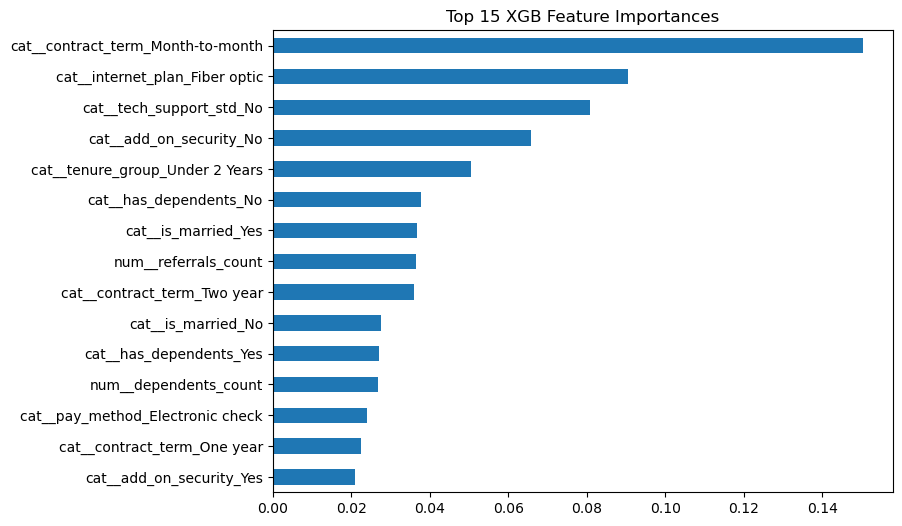

In [12]:
# Get best fitted model from GridSearchCV
best_xgb = xgb_cv.best_estimator_.named_steps["model"]

#get important features
pre = xgb_cv.best_estimator_.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()
imp = pd.Series(best_xgb.feature_importances_, index=feature_names).sort_values(ascending=False)

display(imp.head(15))  # top 15 features


# Optional: plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 XGB Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [13]:
#!pip install shap

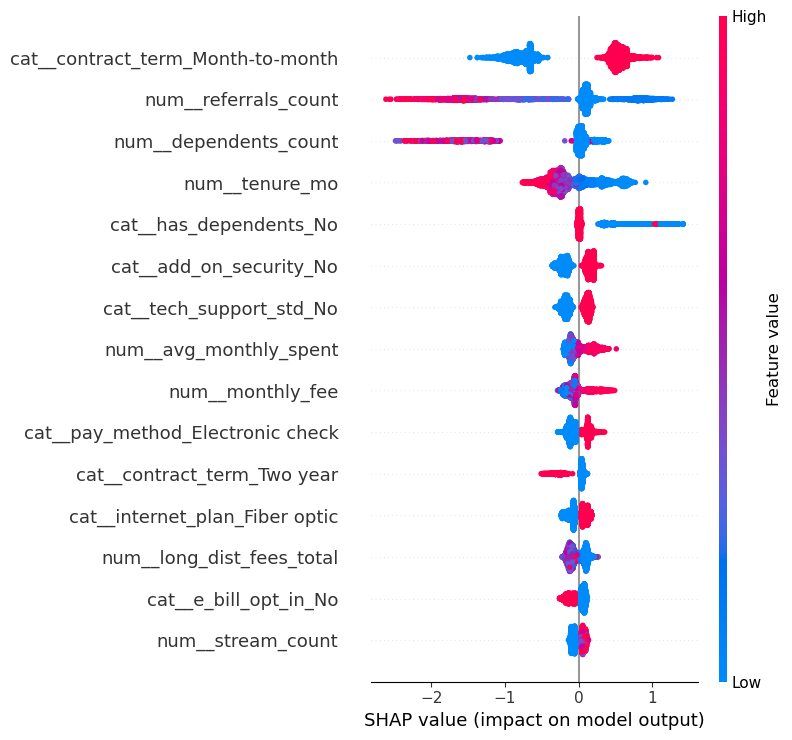

In [14]:
import shap                  

pre = xgb_cv.best_estimator_.named_steps["preprocess"]

#  Transform X the same way the model saw it
X_train_enc = pre.transform(X_train)

#  Get feature names after preprocessing (works for ColumnTransformer / Pipeline in sklearn >= 1.0)
feature_names = None
if hasattr(pre, "get_feature_names_out"):
    feature_names = pre.get_feature_names_out()
    
# Create SHAP explainer for tree-based models (e.g., XGBoost, LightGBM, RandomForest)
explainer   = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the training set
# Each value shows how much a feature pushes a prediction toward class 1 (positive) or class 0 (negative)
shap_values = explainer.shap_values(X_train_enc)

# Overall PLot Beeswarm plot: this shows both which features matter most and the direction of their influence

shap.summary_plot(shap_values, X_train_enc, max_display=15, show=True,feature_names=feature_names)

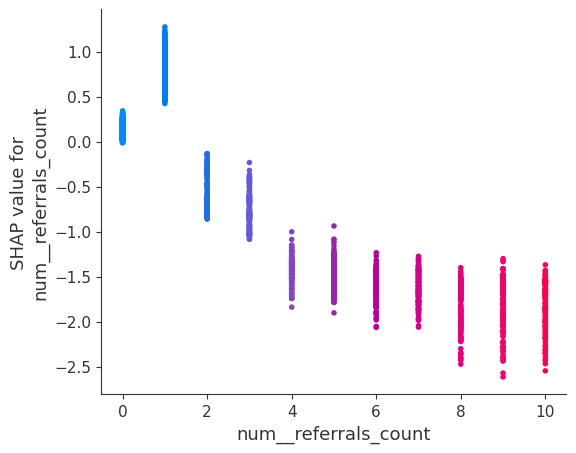

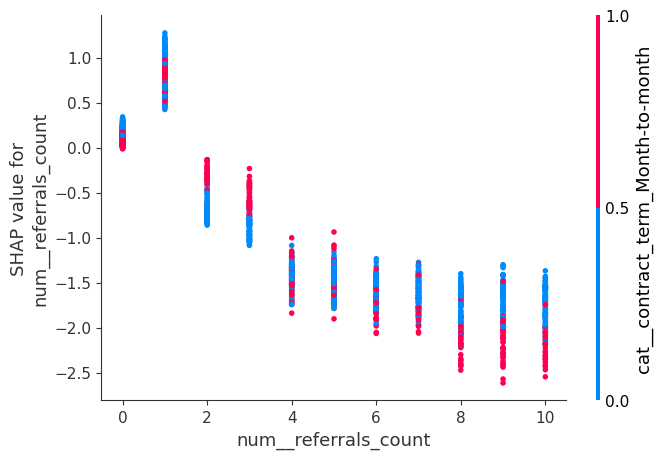

In [15]:
#Dependence plot for one feature
shap.dependence_plot("num__referrals_count", shap_values, X_train_enc, interaction_index="num__referrals_count", show=True,feature_names=feature_names)

# Dependence plot for one feature, colored by another feature
shap.dependence_plot("num__referrals_count", shap_values, X_train_enc, interaction_index="cat__contract_term_Month-to-month", show=True,feature_names=feature_names)

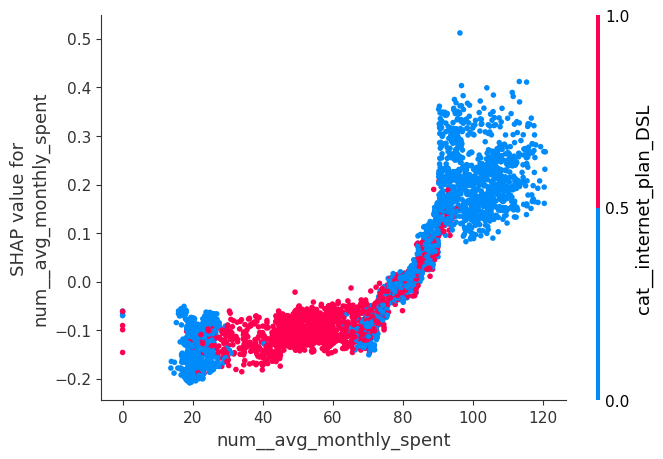

In [16]:
shap.dependence_plot(
    "num__avg_monthly_spent",
    shap_values,
    X_train_enc,
    interaction_index="cat__internet_plan_DSL",
    feature_names=feature_names
)

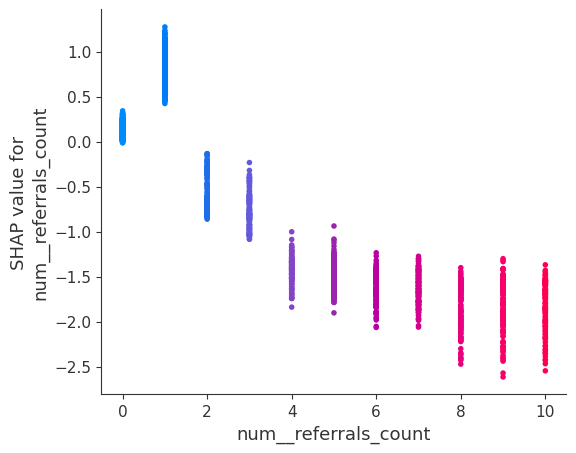

In [17]:
shap.dependence_plot(
    "num__referrals_count",
    shap_values,
    X_train_enc,
    interaction_index="num__referrals_count",
    feature_names=feature_names
)

In [18]:
feature_names

array(['num__tenure_mo', 'num__monthly_fee', 'num__total_billed',
       'num__age_years', 'num__dependents_count', 'num__referrals_count',
       'num__avg_long_dist_fee', 'num__avg_gb_download',
       'num__refunds_total', 'num__extra_data_fees_total',
       'num__long_dist_fees_total', 'num__stream_count',
       'num__add_on_count', 'num__avg_monthly_spent',
       'cat__has_dependents_No', 'cat__has_dependents_Yes',
       'cat__home_phone_No', 'cat__home_phone_Yes', 'cat__multi_line_No',
       'cat__multi_line_No phone service', 'cat__multi_line_Yes',
       'cat__internet_plan_DSL', 'cat__internet_plan_Fiber optic',
       'cat__internet_plan_No', 'cat__add_on_security_No',
       'cat__add_on_security_No internet service',
       'cat__add_on_security_Yes', 'cat__add_on_backup_No',
       'cat__add_on_backup_No internet service', 'cat__add_on_backup_Yes',
       'cat__add_on_protection_No',
       'cat__add_on_protection_No internet service',
       'cat__add_on_protection_Y

In [19]:
Ytest_prob = xgb_cv.predict_proba(X_test)[:, 1]

Test ROC-AUC: 0.9034


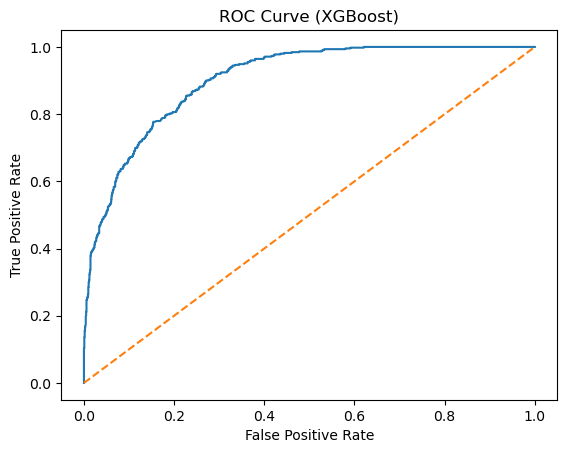

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

test_auc = roc_auc_score(Y_test, Ytest_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC curve (single plot; no custom colors)
fpr, tpr, _ = roc_curve(Y_test, Ytest_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.show()

In [21]:
holdout = pd.read_csv("retentiondata_case_holdout.csv")
print(holdout.describe(include='all'))

          acct_ref      cust_ref has_dependents    tenure_mo home_phone  \
count         1407          1407           1407  1407.000000       1407   
unique        1407          1407              2          NaN          2   
top     ACCT908192  CUST34262714             No          NaN        Yes   
freq             1             1            976          NaN       1282   
mean           NaN           NaN            NaN    32.074627        NaN   
std            NaN           NaN            NaN    24.739484        NaN   
min            NaN           NaN            NaN     0.000000        NaN   
25%            NaN           NaN            NaN     9.000000        NaN   
50%            NaN           NaN            NaN    27.000000        NaN   
75%            NaN           NaN            NaN    56.000000        NaN   
max            NaN           NaN            NaN    72.000000        NaN   

       multi_line internet_plan add_on_security add_on_backup  \
count        1407          1407   

In [32]:
# --- Holdout scoring ---
# OPTIONAL: feature engineering outside the pipeline goes here
# Example:
# holdout["new_feature"] = holdout["colA"] + holdout["colB"]
holdout['stream_count'] = (holdout[['stream_tv', 'stream_movies', 'stream_music']] == 'Yes').sum(axis=1)
holdout['add_on_count'] = (holdout[['add_on_security', 'add_on_backup', 'add_on_protection']] == 'Yes').sum(axis=1)
holdout = holdout.drop(columns = ['acct_ref', 'cust_ref','fiscal_qtr','recent_offer','gender'], axis = 1)
holdout['internet_tech'] = holdout['internet_tech'].fillna("No Internet")
holdout['total_billed'] = holdout['total_billed'].fillna(holdout['total_billed'].median())
holdout['tenure_group'] = pd.cut(
    holdout['tenure_mo'],
    bins=[0, 24, 48, float('inf')],
    labels=['Under 2 Years', '2-4 Years', 'Over 4 Years'],
    right=False
)
holdout['avg_monthly_spent'] = np.where(
    holdout['tenure_mo'] == 0,
    0,
    holdout['total_billed'] / holdout['tenure_mo']
)

KeyError: "['acct_ref', 'cust_ref', 'fiscal_qtr', 'recent_offer', 'gender'] not found in axis"

In [45]:
best_pipe = xgb_cv.best_estimator_

# Predict probabilities using the FULL pipeline (preprocess + model)
Yholdout_proba = best_pipe.predict_proba(holdout)[:, 1]

holdout["Yholdout_proba"] = Yholdout_proba
print(holdout.describe(include='all'))

       has_dependents    tenure_mo home_phone multi_line internet_plan  \
count            1407  1407.000000       1407       1407          1407   
unique              2          NaN          2          3             3   
top                No          NaN        Yes         No   Fiber optic   
freq              976          NaN       1282        686           617   
mean              NaN    32.074627        NaN        NaN           NaN   
std               NaN    24.739484        NaN        NaN           NaN   
min               NaN     0.000000        NaN        NaN           NaN   
25%               NaN     9.000000        NaN        NaN           NaN   
50%               NaN    27.000000        NaN        NaN           NaN   
75%               NaN    56.000000        NaN        NaN           NaN   
max               NaN    72.000000        NaN        NaN           NaN   

       add_on_security add_on_backup add_on_protection tech_support_std  \
count             1407          1407

In [47]:
holdout.to_csv("retentioncase_holdout_scored_for_turnin.csv", index=False)